In [1]:
%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import torch
from transformers import AutoModel, AutoTokenizer
import nlp_utils, keywords_utils, load_utils, run_analysis
from config import *


/home/msalvetti/notebooks_2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-12 09:34:40.014171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate keywords
Ignore if you already have a result for the current run

In [2]:
keywords_df = load_utils.load_keywords(KEYWORDS_FILE)
keywords = keywords_df.select(pl.col("prompt_output").str.to_lowercase().str.join(", ")).item()
kws = [k.strip() for k in keywords.split(", ") if len(k.strip()) > 3]

In [3]:
lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url", "text")
keywords_utils.match_keywords(kws, lf, "text", "url", 5_000, "run_kw_matches")

File ARGUS_chunk_p183.parquet is corrupted
Building automaton with 55443 keywords
Automaton built
Percent completed: 0.42%, Time remaining: 0:22:01
Percent completed: 0.83%, Time remaining: 0:18:10
Percent completed: 1.25%, Time remaining: 0:17:50
Percent completed: 1.66%, Time remaining: 0:19:14
Percent completed: 2.08%, Time remaining: 0:20:53
Percent completed: 2.50%, Time remaining: 0:20:27
Percent completed: 2.91%, Time remaining: 0:19:50
Percent completed: 3.33%, Time remaining: 0:19:53
Percent completed: 3.74%, Time remaining: 0:20:20
Percent completed: 4.16%, Time remaining: 0:20:38
Percent completed: 4.57%, Time remaining: 0:20:08
Percent completed: 4.99%, Time remaining: 0:19:47
Percent completed: 5.41%, Time remaining: 0:21:28
Percent completed: 5.82%, Time remaining: 0:22:16
Percent completed: 6.24%, Time remaining: 0:21:25
Percent completed: 6.65%, Time remaining: 0:21:36
Percent completed: 7.07%, Time remaining: 0:21:34
Percent completed: 7.49%, Time remaining: 0:21:51
Pe

# Load results

In [7]:
lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url")

keywords_df = load_utils.load_keywords(config.KEYWORDS_FILE)
result = load_utils.load_keyword_matches("run_kw_matches.parquet").rename({"ID": "url"})
lookup = keywords_df.with_columns(pl.col("prompt_output").str.split(", ")).explode("prompt_output").rename({"prompt_output": "keyword"})

result = result.join(lookup, on = "keyword").join(lf.collect(engine = "streaming"), on = "url")

File ARGUS_chunk_p183.parquet is corrupted


In [120]:
unique_count = result.group_by("ID", "category").agg(pl.col('keyword').n_unique().alias("n_unique")).filter(pl.col("n_unique") >= 1)

# Analysis

## Survival plot

In [39]:
def find_unique_count(df, tresh):
    return (
        df.filter(pl.col("unique_kw") >= tresh)
        .group_by("category")
        .agg(pl.len())
        .sort("len", descending=True)
    )

keywords_df = pl.read_csv(
    DATA_DIR + "raw/keywords.csv", truncate_ragged_lines=True
)

keywords_df = keywords_df.with_columns(pl.col("prompt_output").str.split(", ")).explode("prompt_output").filter(pl.col("prompt_output").str.len_chars() > 4).unique().group_by("category").agg(pl.col("prompt_output").str.join(", "))

result = pl.read_parquet(DATA_DIR + "processed/kw_matches.parquet")
result = result.filter(pl.col("matches") != [])
result = result.explode("matches").rename({"matches": "keyword"})

# merge to get category
lookup = (
    keywords_df.with_columns(pl.col("prompt_output").str.split(", "))
    .explode("prompt_output")
    .rename({"prompt_output": "keyword"})
)
result = result.join(lookup, on="keyword").rename({"ID": "Publication number"})
patent_company_lookup = load_utils.load_multiple_files(pattern = PATENTS_DIR + "Appl*.csv", filetype="csv")[:, 1:3].rename({"Applicant(s) BvD ID Number(s)": "ID"})
patent_company_lookup = patent_company_lookup.with_columns(pl.col("ID").str.split("; ")).explode("ID")

result = result.join(patent_company_lookup, on = "Publication number", how = "inner")


unique_matches = result.group_by("ID", "category").agg(
    pl.col("keyword").alias("unique_kw").n_unique()
)

name_lookup = (
    pl.read_csv(DATA_DIR + "raw/url_list_employees.csv").rename({"BVD": "ID"}).select("ID", "Name", "Canton", "n_employees")
)

unique_matches = unique_matches.join(name_lookup, on="ID").sort(
    "unique_kw", descending=True
)
unique_count = find_unique_count(unique_matches, 1)

In [19]:
cat_list = (
    unique_count.group_by("category").agg(pl.len()).sort('len', descending = True)
)["category"].to_list()[0:5]

In [ ]:
result.group_by("ID", "category").agg(n_matches = pl.len()).group_by("n_matches").agg(n_companies = pl.len()).sort("n_matches")

n_matches,n_companies
u32,u32
1,7152
2,4977
3,2534
4,2209
5,1157
…,…
3434,1
3752,1
5385,1


In [74]:
plot

n_matches,n_companies
u32,u32
1,7152
2,4977
3,2534
4,2209
5,1157
…,…
3434,1
3752,1
5385,1


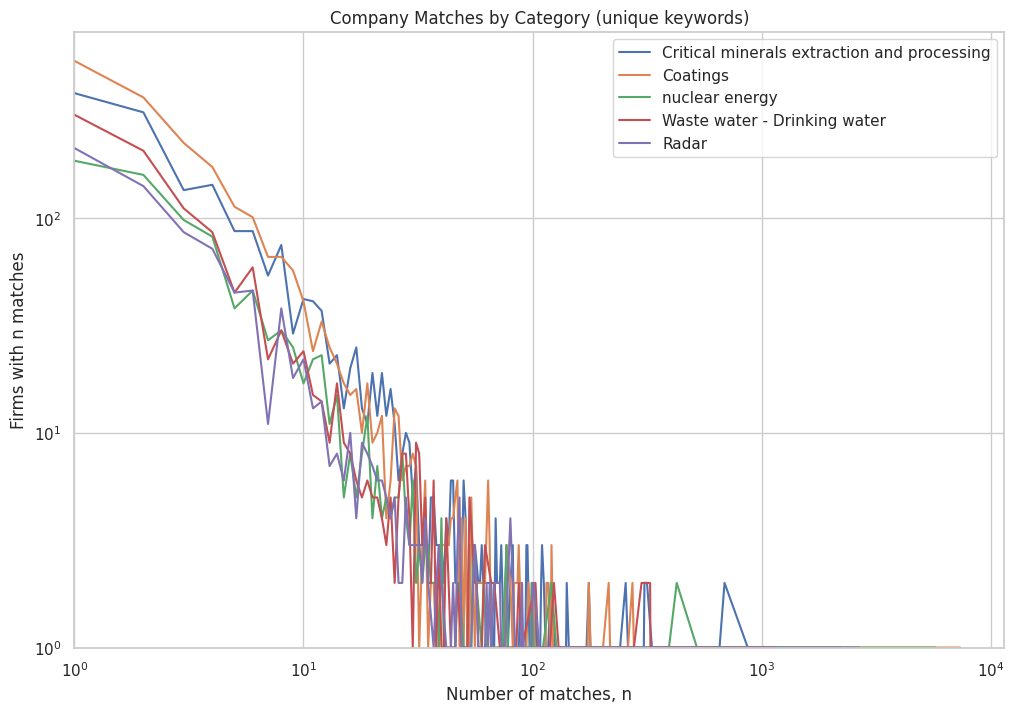

In [85]:
import matplotlib.pyplot as plt
import numpy as np
cat_list = result\
        .group_by("category").agg(pl.len()).sort("len", descending=True)["category"][:5]

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_xlabel("Number of uniuqe keyword matches")
ax.set_ylabel("Number of Companies")
ax.set_title("Company Matches by Category (unique keywords)")
for x in cat_list:
    plot = (
        result.filter(pl.col("category") == x)
        .group_by("ID", "category")
        .agg(n_matches = pl.len())
        .group_by("n_matches")
        .agg(n_companies = pl.len())
        .sort("n_matches")
    )
    plt.plot(plot["n_matches"], plot["n_companies"], label = x)
plt.yscale("log")
plt.xscale("log")

ax.set_xlabel("Number of matches, n")
ax.set_ylabel("Firms with n matches")
start, end = ax.get_xlim()
# plt.xticks(np.arange(int(start), int(end), 5))
ax.set_ylim(1)
ax.set_xlim(1)
ax.legend()

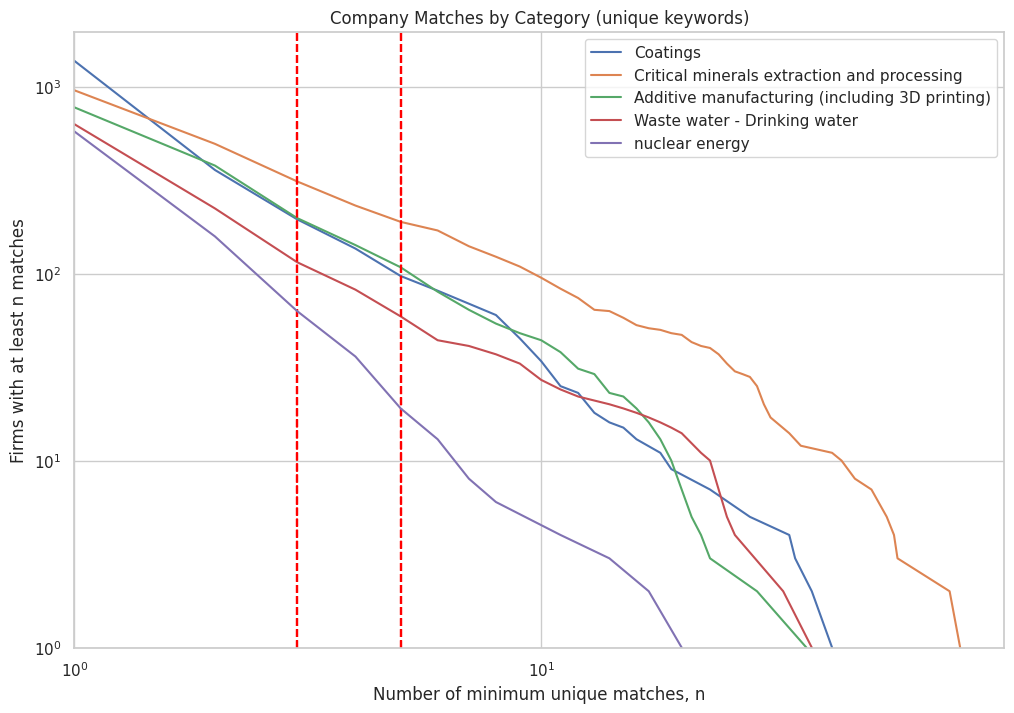

In [57]:
import matplotlib.pyplot as plt
import numpy as np
cat_list = unique_matches\
        .filter(pl.col("unique_kw") >= 1)\
        .group_by("category").agg(pl.len()).sort("len", descending=True)["category"][:5]

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_xlabel("Number of uniuqe keyword matches")
ax.set_ylabel("Number of Companies")
ax.set_title("Company Matches by Category (unique keywords)")
for x in cat_list:
    plot = (
        unique_matches.filter(pl.col("unique_kw") >= 1)\
        .filter(pl.col("category") == x).group_by('unique_kw').agg(pl.len())\
        .sort("unique_kw").with_columns(pl.col("len").cum_sum(reverse=True))
    )
    plt.axvline(3, color="red", linestyle="--")
    plt.axvline(5, color="red", linestyle="--")
    plt.plot(plot["unique_kw"], plot["len"], label = x)
    plt.yscale("log")
    plt.xscale("log")

ax.set_xlabel("Number of minimum unique matches, n")
ax.set_ylabel("Firms with at least n matches")
start, end = ax.get_xlim()
# plt.xticks(np.arange(int(start), int(end), 5))
ax.set_ylim(1)
ax.set_xlim(1)
ax.legend()

## Elbow plot

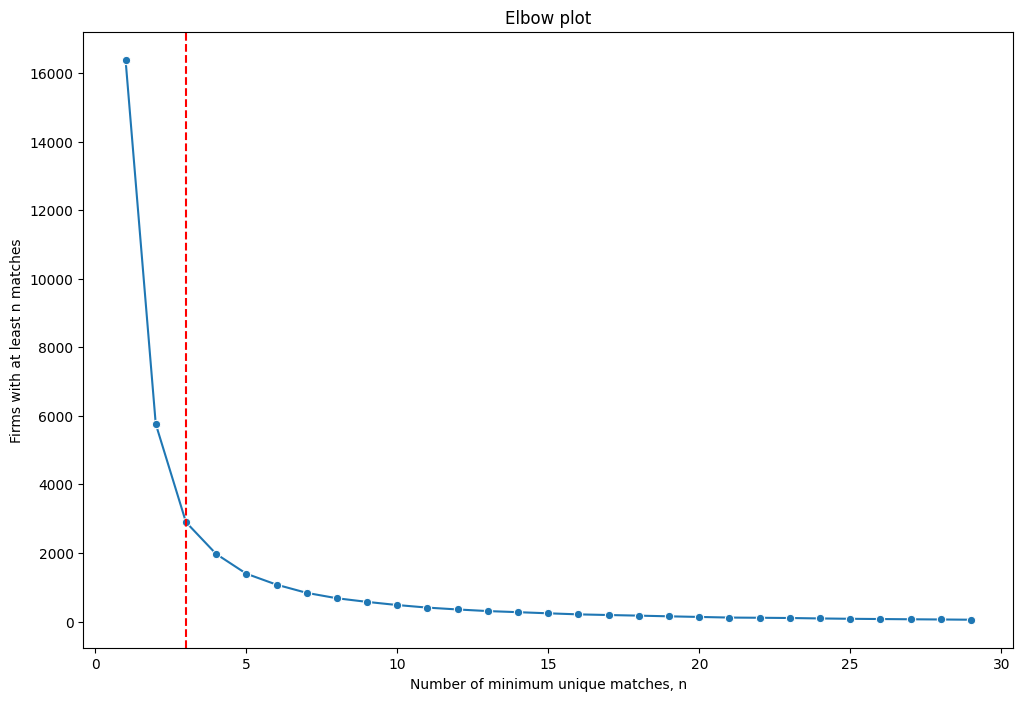

In [43]:
import seaborn as sns
 
top = pl.DataFrame(schema={"tresh": pl.Int64, "n_matches": pl.Int64})
for i in range(1, 30):
    top_result = find_unique_count(unique_matches, i).select("len").sum().item()
    data = pl.DataFrame({"tresh": [i], "n_matches": [top_result]})
    top.extend(data)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(y=top["n_matches"], x=top["tresh"], marker="o")
plt.axvline(3, color="red", linestyle="--")
# plt.text(3.5, 17500, "Treshold = 3")
ax.set_xlabel("Number of minimum unique matches, n")
ax.set_ylabel("Firms with at least n matches")
ax.set_title("Elbow plot")
plt.savefig(f"/home/msalvetti/send_to_mac/elbow_plot.png")

## Canton Comparison

298 966


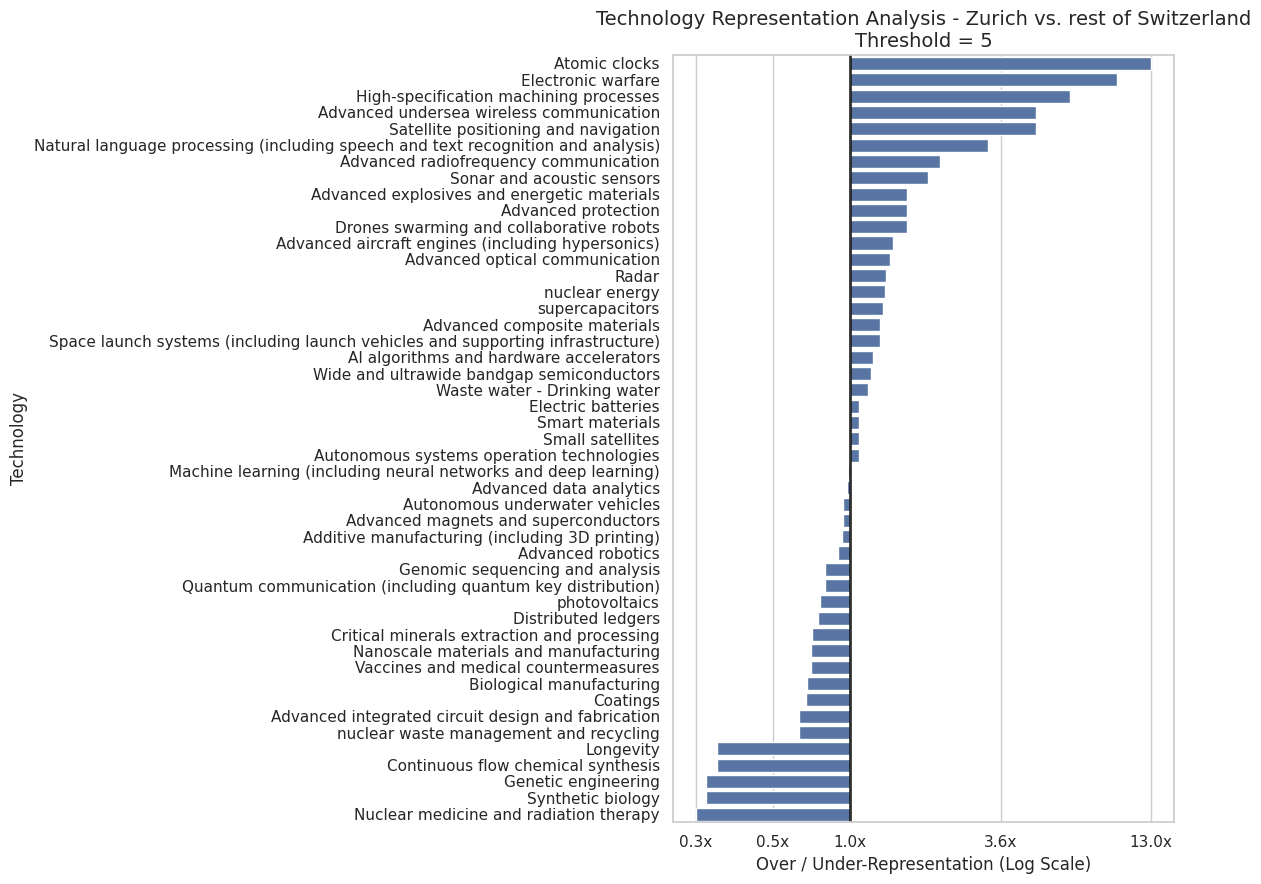

In [63]:
def compare_canton(df: pl.DataFrame, canton: str, thresh: int) -> pl.DataFrame:
    canton_unique = unique_matches.filter(pl.col("unique_kw") >= thresh).filter(
        pl.col("Canton") == canton
    )
    others_unique = unique_matches.filter(pl.col("unique_kw") >= thresh).filter(
        pl.col("Canton") != canton
    )

    canton_unique = canton_unique.group_by("category").agg(
        pl.len().alias(f"count_{canton}")
    )
    others_unique = others_unique.group_by("category").agg(
        pl.len().alias("count_others")
    )

    plot_data = canton_unique.join(others_unique, on="category")

    n_canton = plot_data.select(f"count_{canton}").sum().item()
    n_others = plot_data.select("count_others").sum().item()
    print(n_canton, n_others)

    plot_data = (
        plot_data.with_columns(
            (pl.col("count_" + canton) / n_canton).alias(f"percent_{canton}"),
        )
        .with_columns(
            (pl.col("count_others") / n_others).alias("percent_others"),
        )
        .with_columns(
            (pl.col("percent_" + canton) / pl.col("percent_others")).alias("ratio")
        )
        .with_columns(pl.col("ratio").log10().alias("logRTA"))
        .sort("logRTA", descending=True)
    )
    return plot_data


canton = "Zurich"
thresh = 5
plot_data = compare_canton(unique_matches, canton, thresh)

fig, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x=plot_data["logRTA"], y=plot_data["category"])
ax.axvline(0, color="black", linestyle="-", linewidth=2, alpha=0.8)

ax.set_ylabel("Technology")
ax.set_xlabel("Over- or Under-Representation (RTA)")
min_rta = plot_data["logRTA"].min()
max_rta = plot_data["logRTA"].max()
x_ticks = [min_rta, min_rta / 2, 0, max_rta / 2, max_rta]
x_labels = [f"{10**xt:.1f}x" for xt in x_ticks]
# x_labels = ["-80%", "-40%", "0%", "+50%", "+100%"]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_title(
    f"Technology Representation Analysis - {canton} vs. rest of Switzerland\nThreshold = {thresh}",
    fontsize=14,
)
ax.set_xlabel("Over / Under-Representation (Log Scale)", fontsize=12)

plt.tight_layout()
plt.show()

## Heatmap

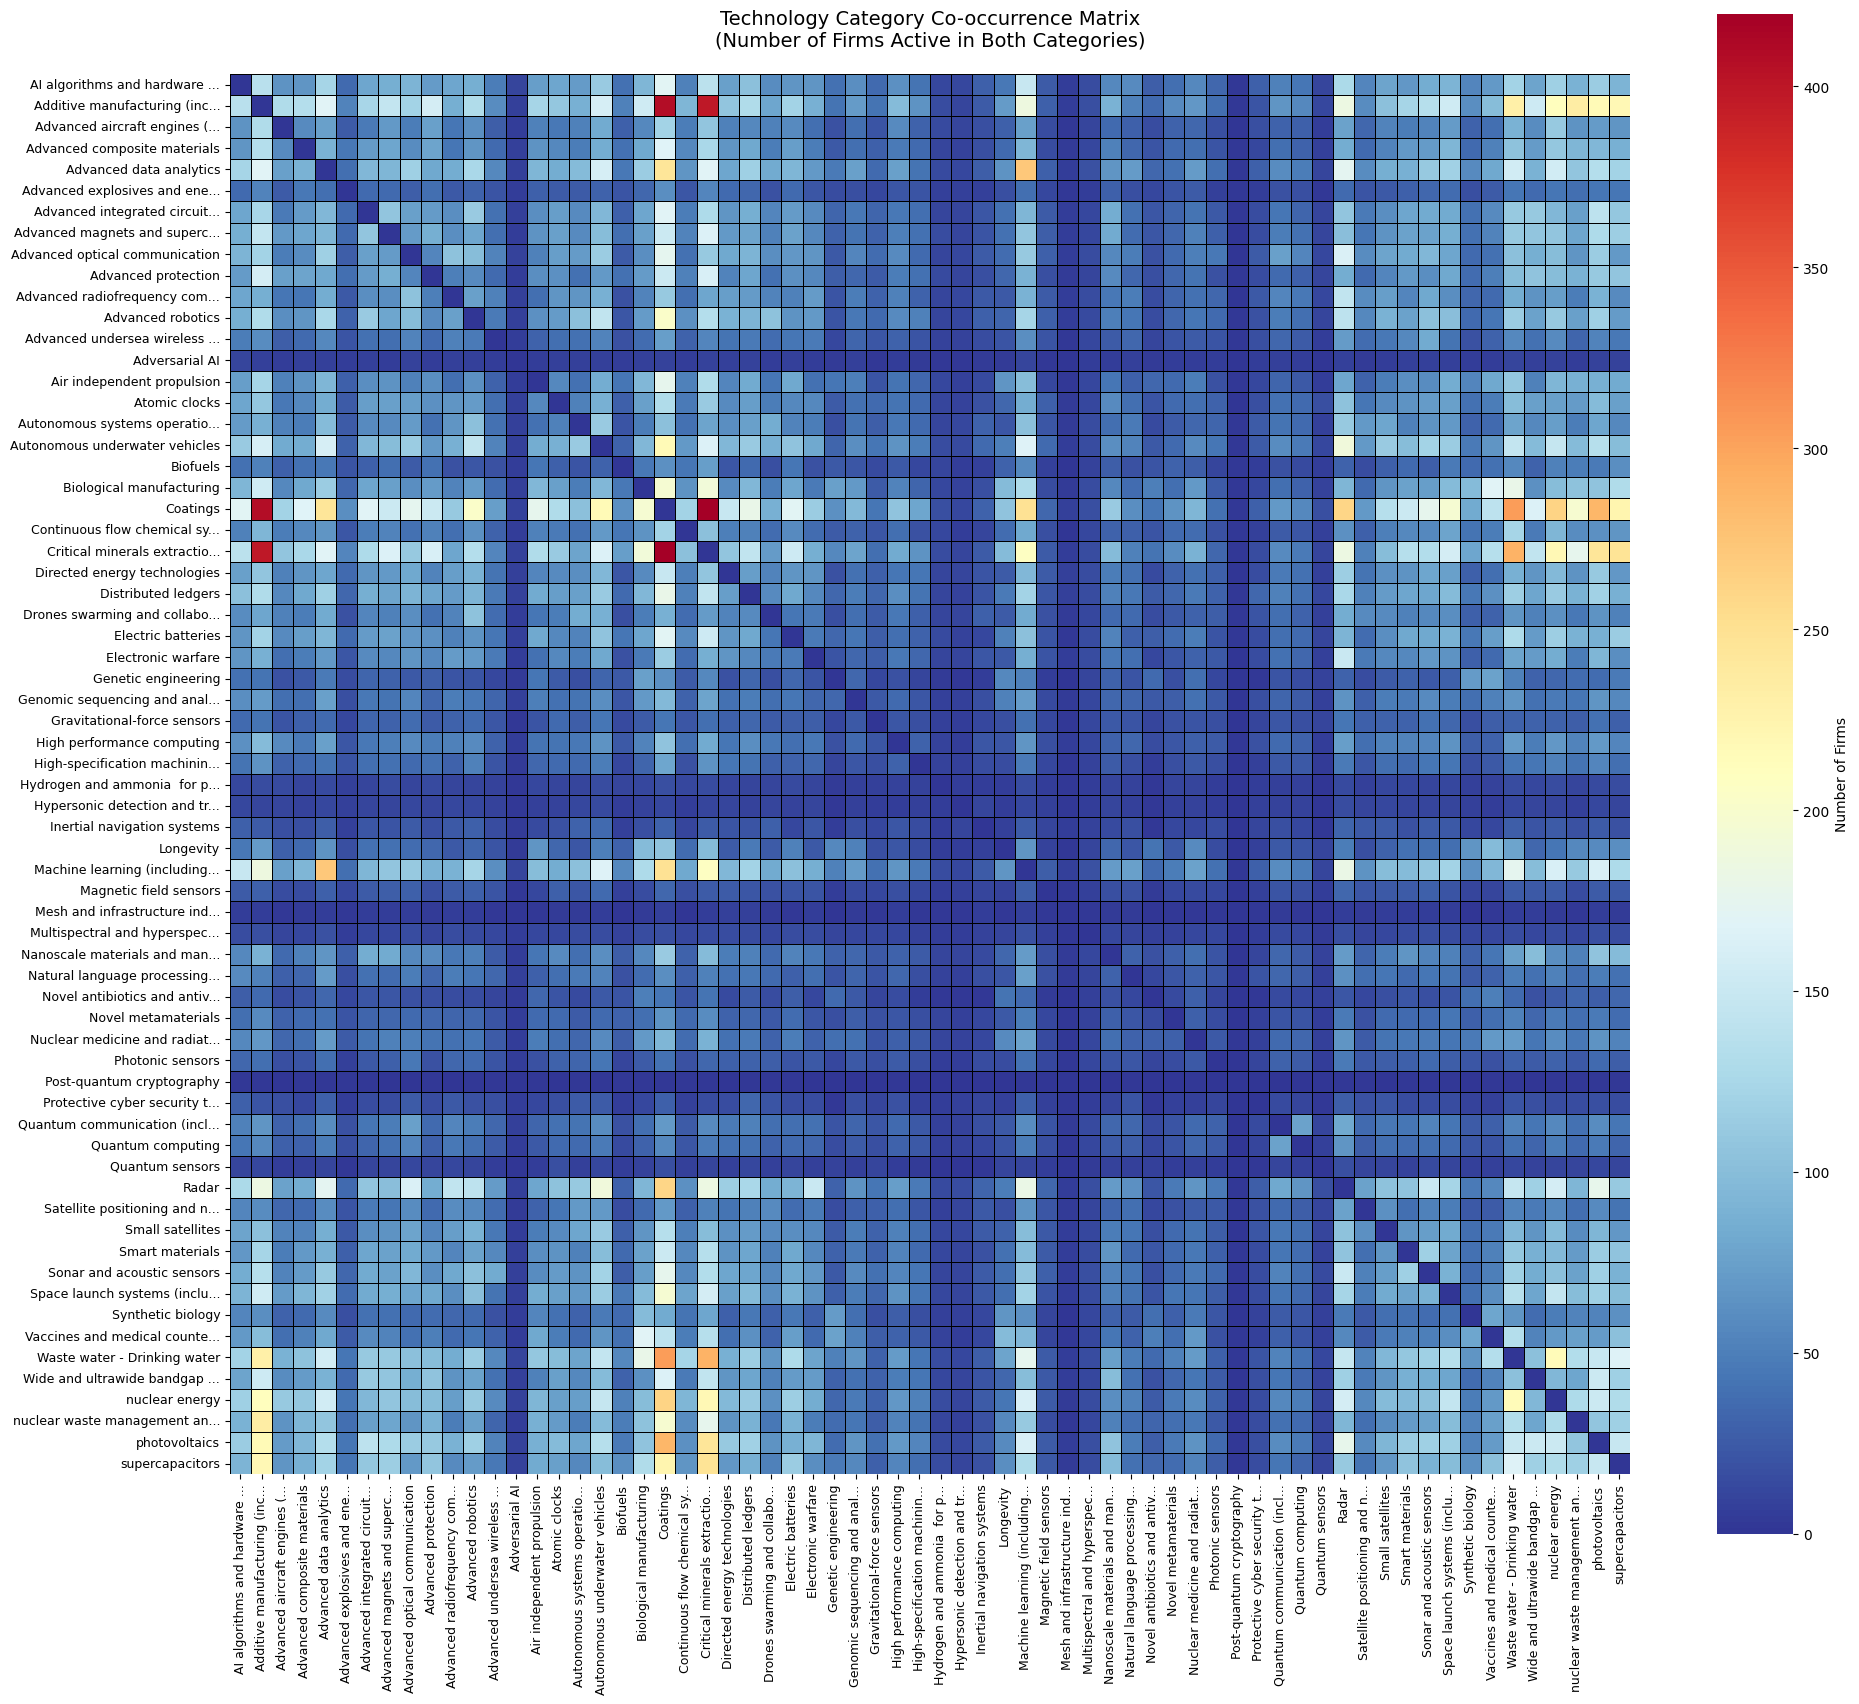

In [45]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get categories and create short labels
categories_full = (
    unique_matches.select("category").unique().sort("category")["category"].to_list()
)


# Create shortened labels for readability
def shorten_label(text, max_len=30):
    return text if len(text) <= max_len else text[: max_len - 3] + "..."


categories_short = [shorten_label(cat) for cat in categories_full]

# Build co-occurrence matrix (same as before)
n_cats = len(categories_full)
cat_to_idx = {cat: i for i, cat in enumerate(categories_full)}
co_matrix = np.zeros((n_cats, n_cats), dtype=int)

firms = unique_matches.group_by("ID").agg(pl.col("category").unique().alias("cats"))

for cats in firms["cats"]:
    for i, cat1 in enumerate(cats):
        for j, cat2 in enumerate(cats):
            idx1 = cat_to_idx[cat1]
            idx2 = cat_to_idx[cat2]
            co_matrix[idx1, idx2] += 1

# Remove diagonal
np.fill_diagonal(co_matrix, 0)

# Create DataFrame with short labels
co_df = pd.DataFrame(co_matrix, index=categories_short, columns=categories_short)

# Create heatmap
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(
    co_df,
    # annot=True,
    fmt="d",
    cmap="RdYlBu_r",  # Reversed color: red=high, blue=low
    cbar_kws={"label": "Number of Firms", "shrink": 0.8},
    square=True,
    linewidths=0.5,
    linecolor="black",
    vmin=0,  # Minimum value for color scale
    # vmax=50,            # Optionally set max to control color range
)

plt.title(
    "Technology Category Co-occurrence Matrix\n(Number of Firms Active in Both Categories)",
    fontsize=14,
    pad=20,
)
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
# plt.savefig('co_occurrence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### https://seaborn.pydata.org/generated/seaborn.clustermap.html
### See this tomorrow

## Keywords numebers comparison

In [46]:
match_1 = result.group_by('ID', "category").agg(pl.len()).group_by("category").agg(pl.len().alias("1 or more matches"))
match_10 = result.group_by("ID", "category").agg(pl.len()).filter(pl.col('len') >= 10).group_by("category").agg(pl.len().alias('10 or more matches'))
match_50 = result.group_by("ID", "category").agg(pl.len()).filter(pl.col("len") >= 50).group_by("category").agg(pl.len().alias("50 or more matches"))

matches = match_1.join(match_50, on = "category").join(match_10, on = "category")
matches = matches.unpivot(["1 or more matches", "50 or more matches", "10 or more matches"], index = "category").sort("value", descending = True)
matches = matches.rename({"variable": "Number of matching keywords", "value": "Number of matches"})

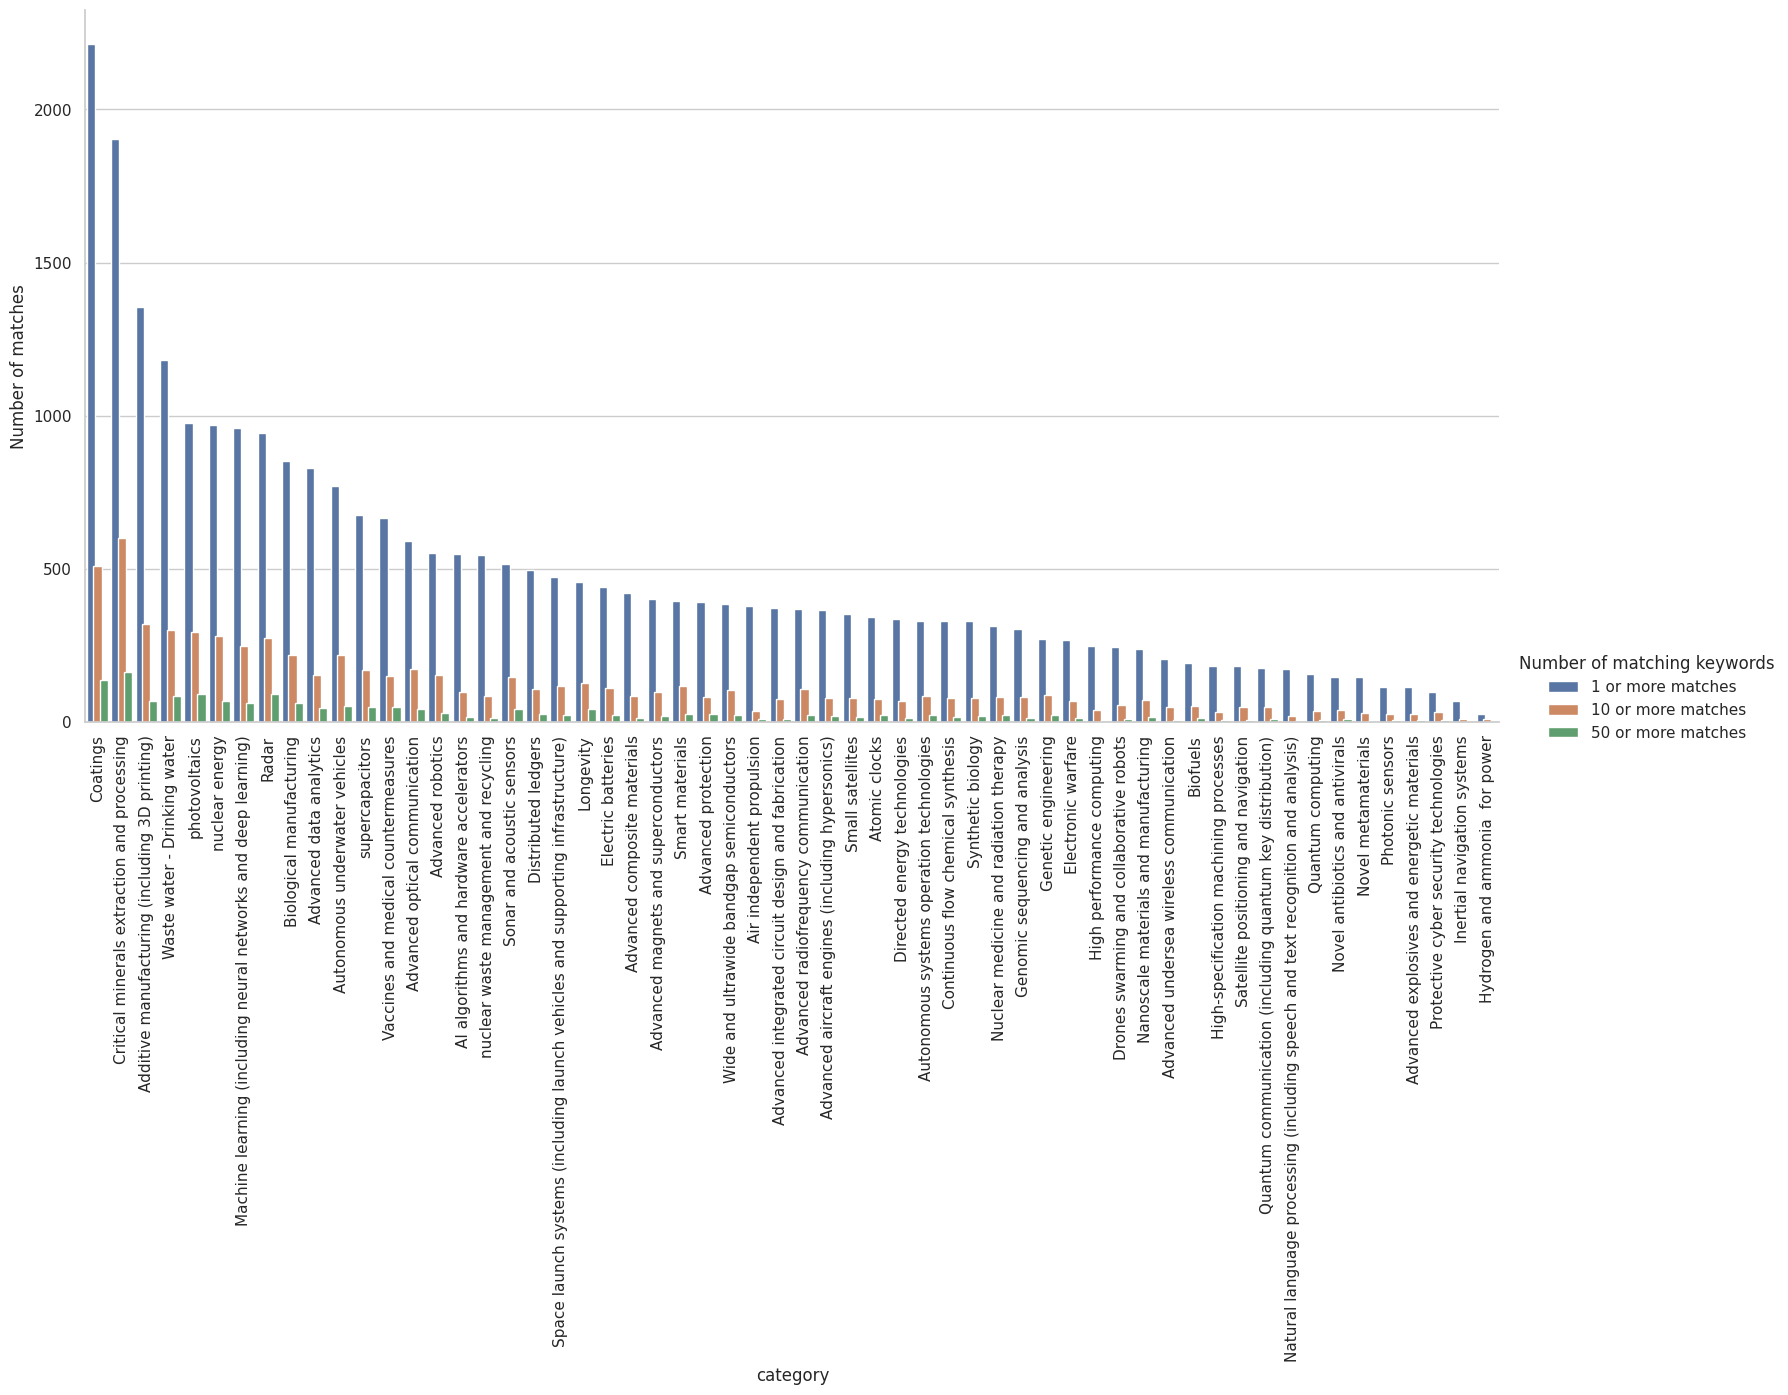

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style='whitegrid')

g = sns.catplot(
    matches, kind = 'bar', x = "category", y = "Number of matches", hue = "Number of matching keywords",
    height= 8,
    aspect=2, 
    native_scale=True
)
for ax in g.axes.flat:
    for patch in ax.patches:
        current_width = patch.get_width()
        new_width = current_width * 1.25  # Increase width by 50%
        diff = new_width - current_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() - diff / 2)  # Center the bar

g.set_xticklabels(rotation=90)

In [49]:
match_1 = unique_matches.group_by("category").agg(pl.len().alias("1 or more unique keywords"))
match_3 = unique_matches.filter(pl.col("unique_kw") >= 3).group_by("category").agg(pl.len().alias('3 or more unique keywords'))
match_5 = unique_matches.filter(pl.col("unique_kw") >= 5).group_by("category").agg(pl.len().alias("5 or more unique keywords"))

unique_matches_nkw = match_1.join(match_5, on = "category", how = 'outer').join(match_3, on = "category", how = 'outer', suffix = "_3")
unique_matches_kw = unique_matches_nkw.unpivot(["1 or more unique keywords", "5 or more unique keywords", "3 or more unique keywords"], index = "category").fill_null(0).sort("value", descending = True)
unique_matches_kw = unique_matches_kw.fill_null(0).rename({"variable": "Number of unique keywords", "value": "Number of matches"})

/tmp/ipykernel_8324/1332805905.py:5: DeprecationWarning: use of `how='outer'` should be replaced with `how='full'`.
(Deprecated in version 0.20.29)
  unique_matches_nkw = match_1.join(match_5, on = "category", how = 'outer').join(match_3, on = "category", how = 'outer', suffix = "_3")


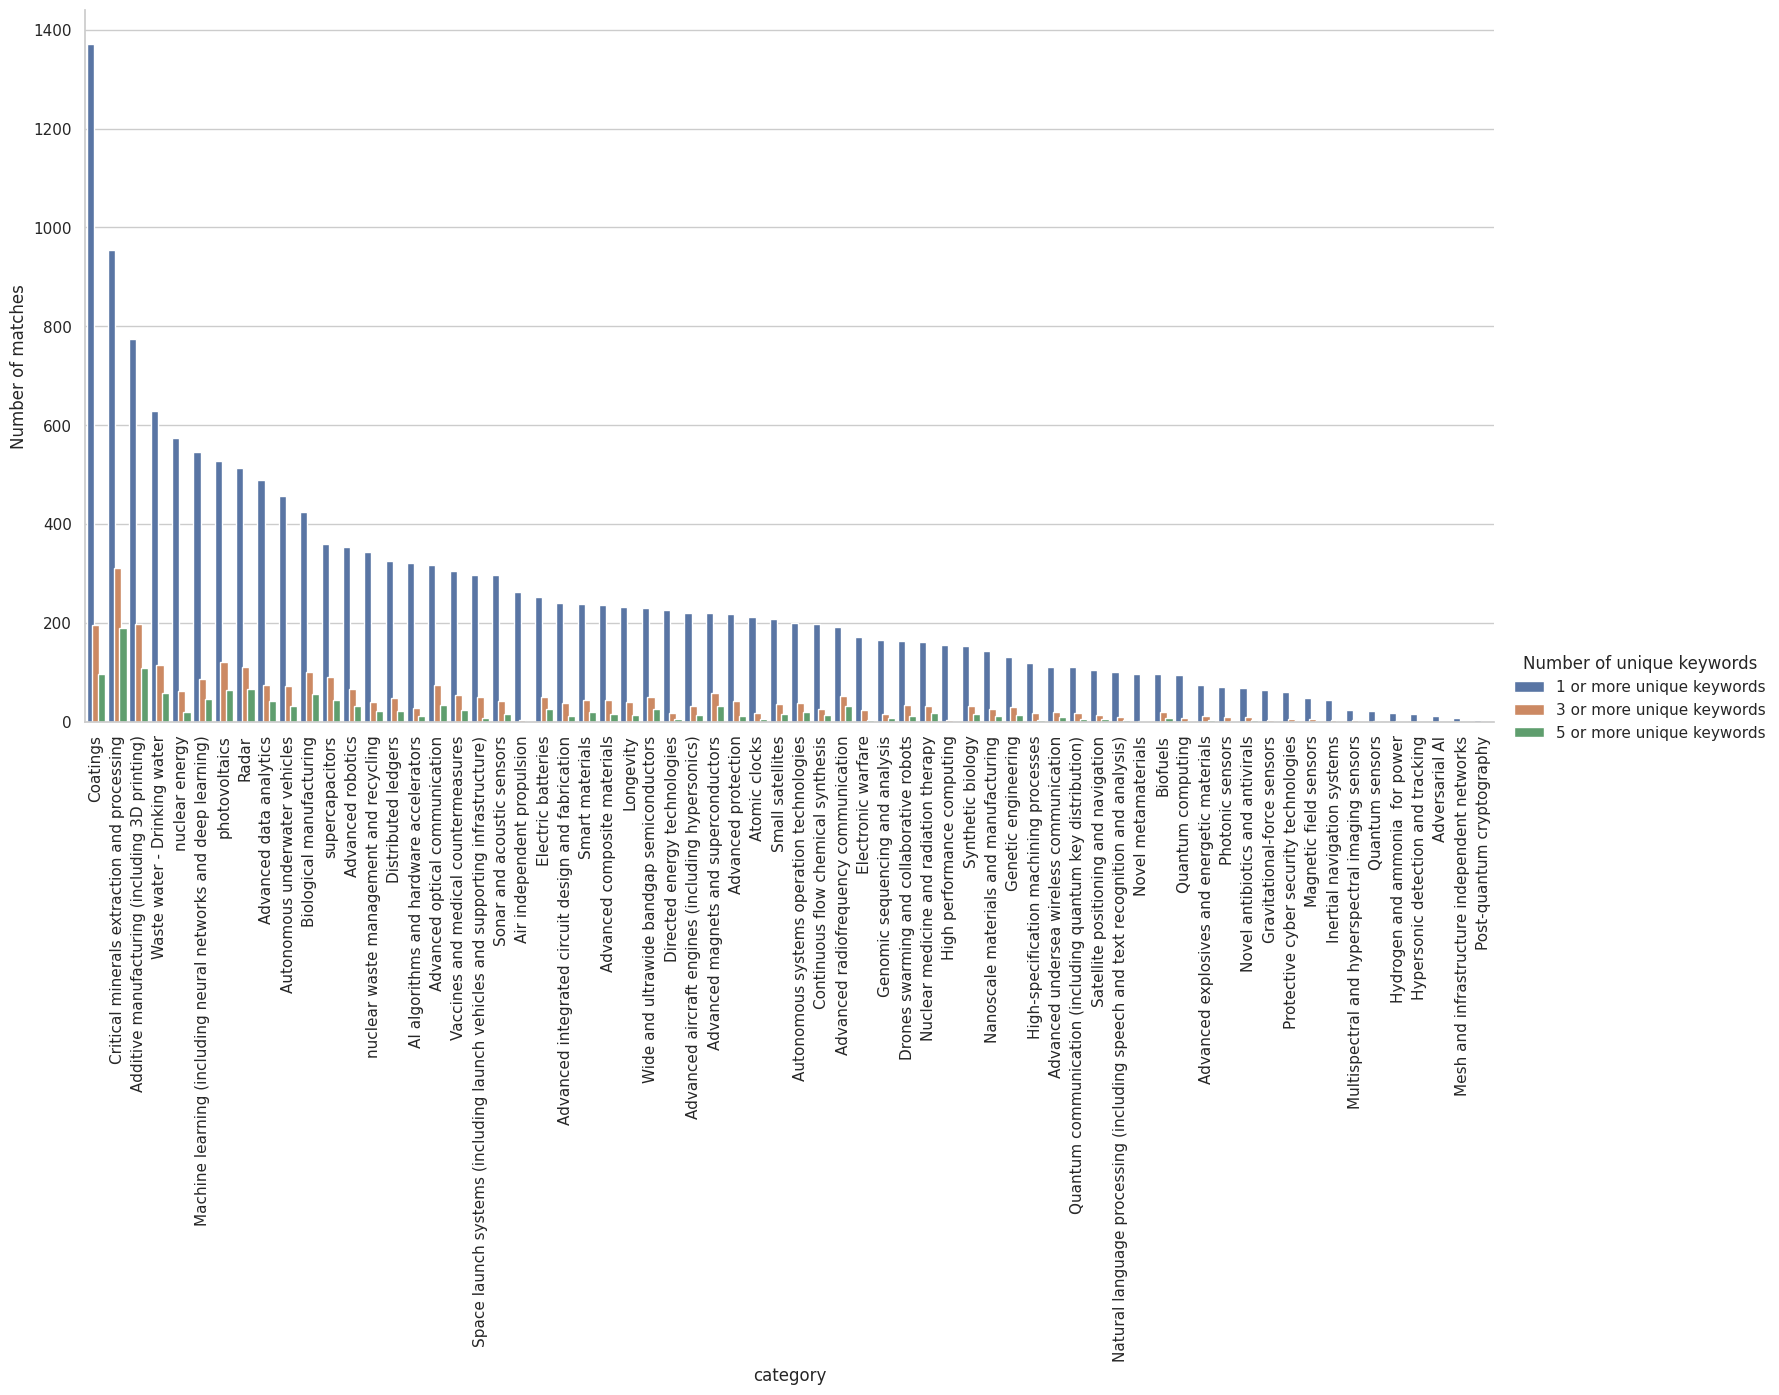

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style='whitegrid')

g = sns.catplot(
    unique_matches_kw, kind = 'bar', x = "category", y = "Number of matches", hue = "Number of unique keywords",
    height= 8,
    aspect=2, 
    native_scale=True
)
for ax in g.axes.flat:
    for patch in ax.patches:
        current_width = patch.get_width()
        new_width = current_width * 1.25  # Increase width by 50%
        diff = new_width - current_width
        patch.set_width(new_width)
        patch.set_x(patch.get_x() - diff / 2)  # Center the bar

g.set_xticklabels(rotation=90)

# Comparison between patents and keywords

In [7]:
%load_ext autoreload
%autoreload

import os, sys

modules = os.path.abspath(os.path.join("..", "src"))
sys.path.append(modules)

import torch
from transformers import AutoModel, AutoTokenizer
import nlp_utils, keywords_utils, load_utils, run_analysis
from config import *

lf = load_utils.load_parquets("/home/msalvetti/KOFScraper/chunks/run_id=2025-11-21/parsed").select("ID", "url")

keywords_df = load_utils.load_keywords(KEYWORDS_FILE)
result = load_utils.load_keyword_matches("run_kw_matches.parquet").rename({"ID": "url"})
lookup = keywords_df.with_columns(pl.col("prompt_output").str.split(", ")).explode("prompt_output").rename({"prompt_output": "keyword"})

# result = result.join(lookup, on = "keyword").join(lf.collect(engine = "streaming"), on = "url")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
File ARGUS_chunk_p183.parquet is corrupted


In [8]:
result

url,keyword
str,str
"""IL97013A""","""sds page"""
"""IL97013A""","""sds page"""
"""IN77KON2004A""","""strip"""
"""IN77KON2004A""","""strip"""
"""IN77KON2004A""","""strip"""
…,…
"""CA2511009C""","""isocyanate"""
"""CA2511009C""","""alkylester"""
"""CA2511031C""","""thread"""
